In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# dataset paths
data_train_path = './train_folder'
data_test_path = './test_folder'

# Classes
classes = os.listdir(data_train_path)
# classes = [cls for cls in os.listdir(data_train_path) if cls != 'Woodpecker']
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 9


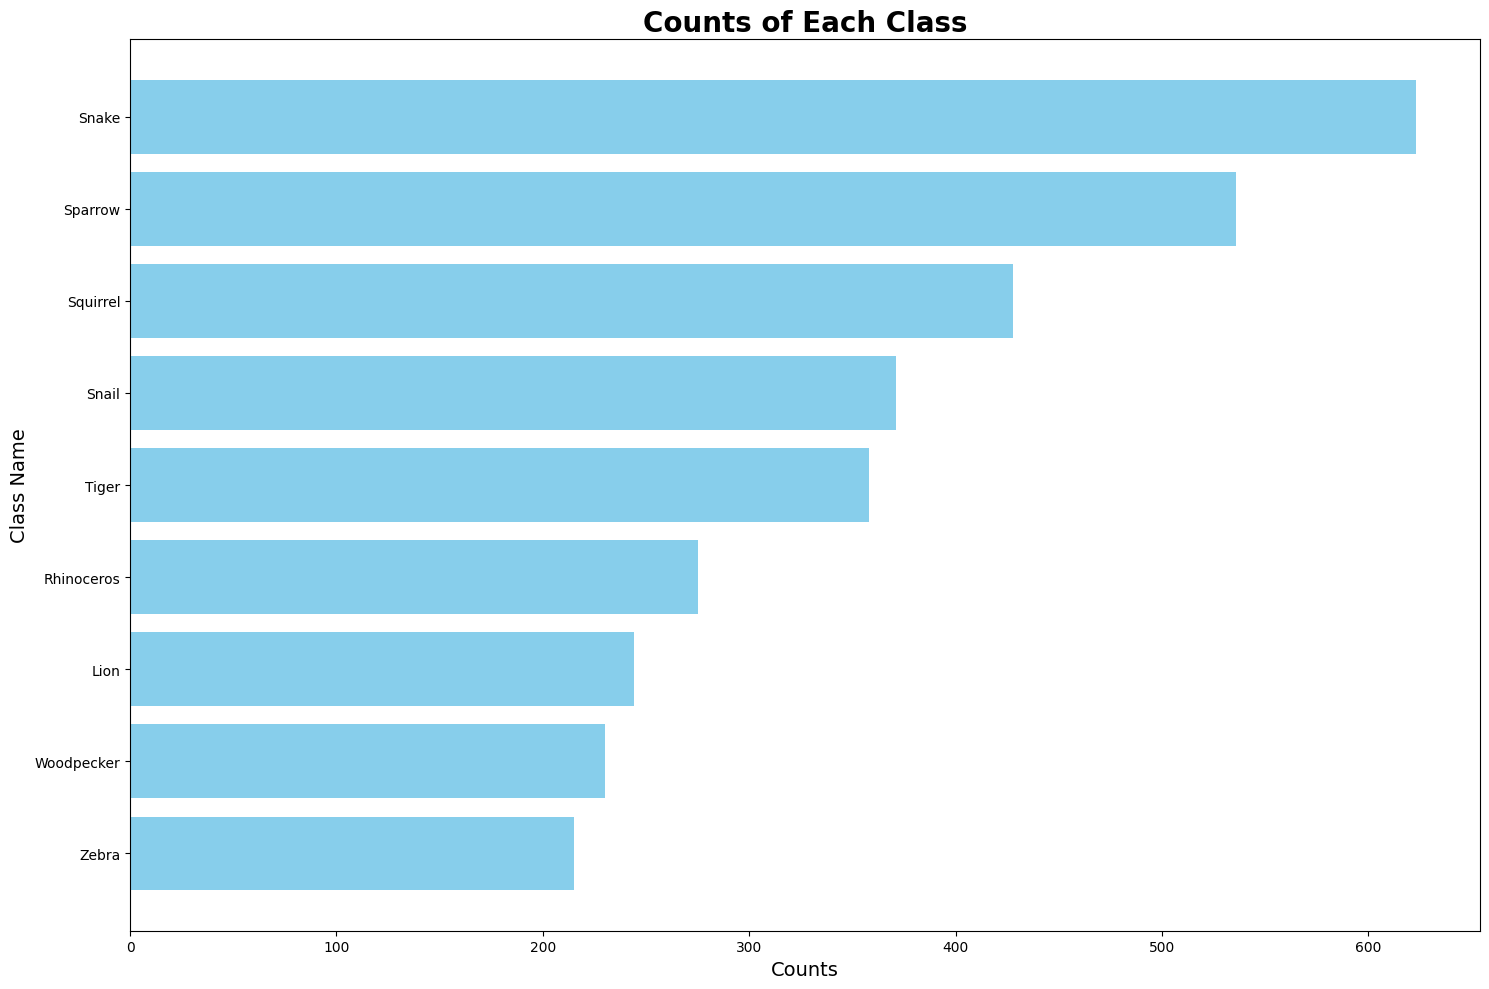

In [3]:
counts = []

for n_class in classes:
    class_path = os.path.join(data_train_path, n_class)
    count = len(os.listdir(class_path))
    counts.append((n_class, count))

counts = pd.DataFrame(counts, columns=['Class Name', 'Counts'])

counts = counts.sort_values(by='Counts', ascending=False)

plt.figure(figsize=(15, 10))
plt.barh(counts['Class Name'], counts['Counts'], color='skyblue')
plt.xlabel('Counts', fontsize=14)
plt.ylabel('Class Name', fontsize=14)
plt.title('Counts of Each Class', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

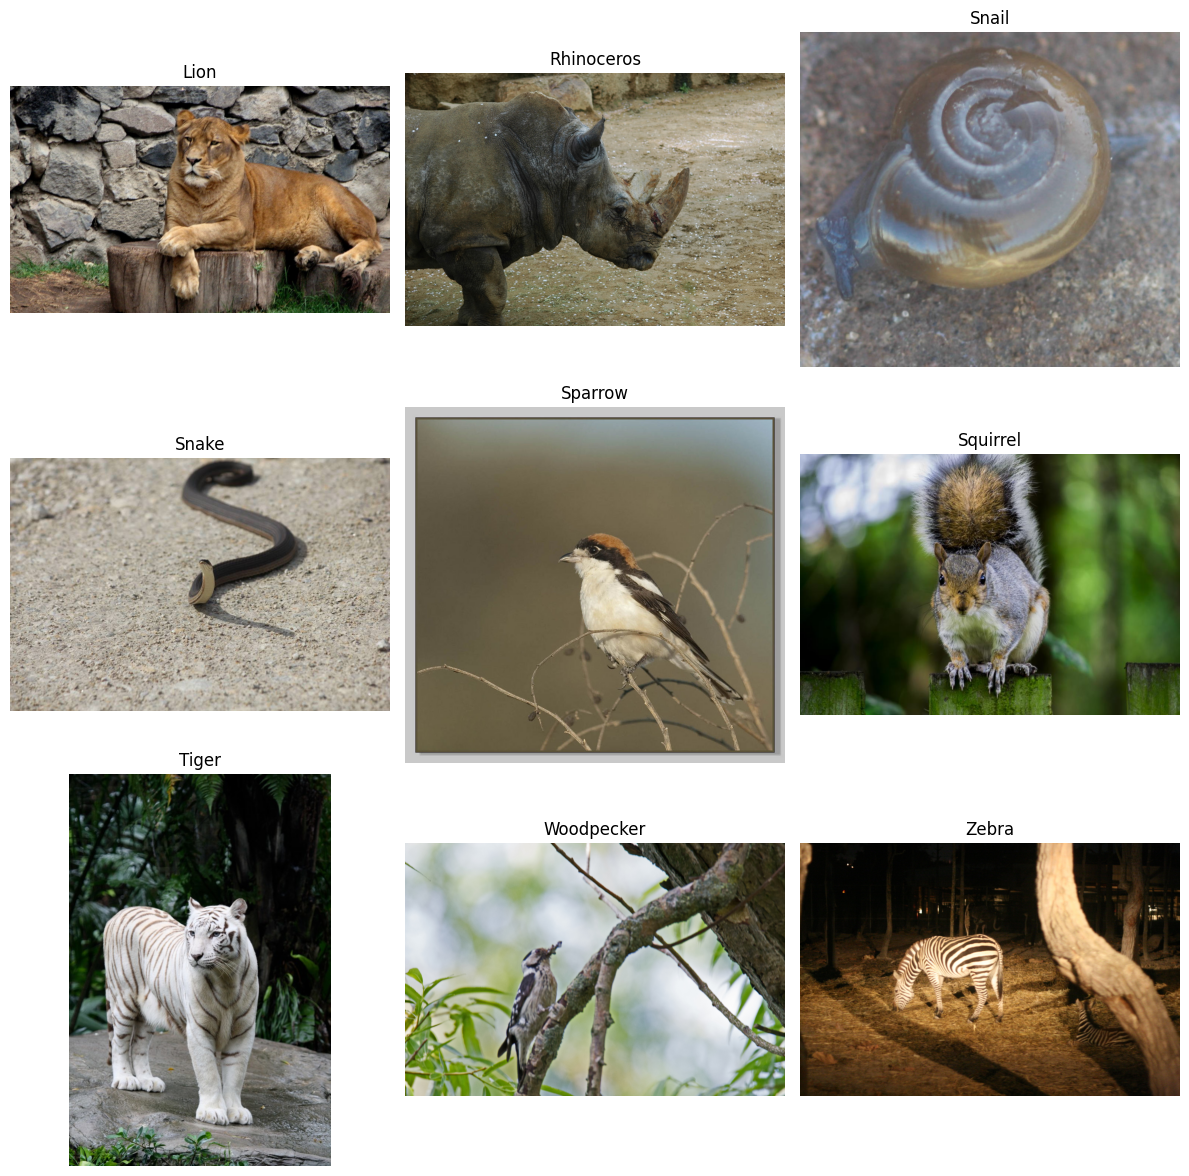

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))  # grelha 3x3 para 9 classes

for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(data_train_path, class_name)
    
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])
    
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    row = i // 3
    col = i % 3

    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    ax[row, col].set_title(class_name)

plt.tight_layout()
plt.show()

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SIZE = IMAGE_SIZE[0]

# Load the full training dataset (will be split later)
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Preprocessing and performance optimization
full_train_ds = full_train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Count total number of batches
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
train_batches = int(0.9 * total_batches)
val_batches = total_batches - train_batches

# Dividir o dataset em treino (90%) e validação (10%)
train_ds = full_train_ds.take(train_batches)
valid_ds = full_train_ds.skip(train_batches)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply augmentation and normalization to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Apply only normalization to validation set
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Split the dataset: 90% for training and 10% for validation
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print("Total batches:", total_batches + tf.data.experimental.cardinality(test_ds).numpy())
print("Train batches:", train_batches)
print("Validation batches:", val_batches)
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Found 3271 files belonging to 9 classes.
Found 744 files belonging to 9 classes.
Total batches: 127
Train batches: 92
Validation batches: 11
Test batches: 24


In [6]:
from tensorflow.keras.applications import MobileNetV2

# Carregar o modelo base com pesos do ImageNet, sem a "top" (camadas finais de classificação do ImageNet)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar as camadas do modelo base para não serem treinadas inicialmente
base_model.trainable = False

# Construir o novo modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # camada final para classificação multi-classe
])

# 3. Compilar o modelo (fase 1: apenas cabeça)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Treinar a cabeça
history = model.fit(train_ds, epochs=10, validation_data=valid_ds)

# 5. Fine-tuning: descongelar últimas camadas do backbone
base_model.trainable = True
for layer in base_model.layers[:-30]:  # só as últimas 30 camadas vão ser treinadas
    layer.trainable = False

# 6. Recompilar com learning rate mais baixo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 7. Treinar novamente com fine-tuning
fine_tune_history = model.fit(train_ds, epochs=10, validation_data=valid_ds)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 770ms/step - accuracy: 0.3372 - loss: 2.0069 - val_accuracy: 0.9290 - val_loss: 0.5535
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 714ms/step - accuracy: 0.7861 - loss: 0.7826 - val_accuracy: 0.9545 - val_loss: 0.2653
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 677ms/step - accuracy: 0.8682 - loss: 0.4631 - val_accuracy: 0.9688 - val_loss: 0.1717
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 673ms/step - accuracy: 0.8707 - loss: 0.4337 - val_accuracy: 0.9460 - val_loss: 0.1763
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 653ms/step - accuracy: 0.9021 - loss: 0.3170 - val_accuracy: 0.9489 - val_loss: 0.1561
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 674ms/step - accuracy: 0.9087 - loss: 0.3026 - val_accuracy: 0.9744 - val_loss: 0.1036
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 651ms/step - accuracy: 0.9102 - loss: 0.3002 - val_accuracy: 0.9688 - val_loss: 0.1160
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 664ms/

In [7]:
# Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# # Train model by .fit function
# history = model.fit(
#     train_ds,                                          # Dataset to train model
#     epochs=30,                                        # Number of epochs to train
#     validation_data=valid_ds                          # Validation dataset
# )

In [9]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

accuracy      loss  val_accuracy  val_loss
5  0.910243  0.300321      0.974432  0.103640
6  0.917437  0.275584      0.968750  0.115984
7  0.921548  0.257659      0.985795  0.081033
8  0.917799  0.246035      0.988636  0.072755
9  0.923604  0.235849      0.968750  0.123108

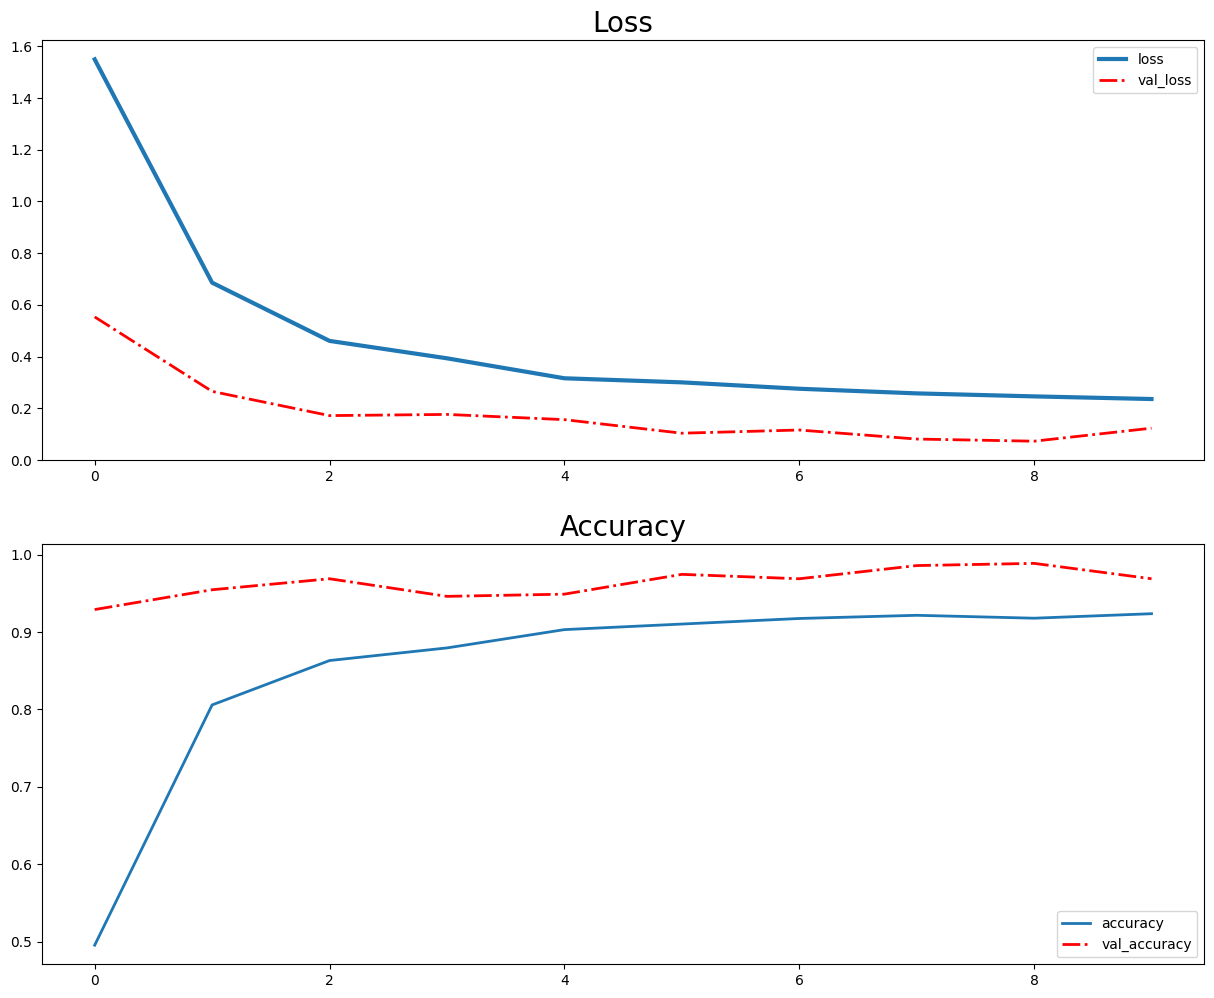

In [10]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

# #  AX2 : Loss
# ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
# ax[2].set_title('learning_rate', fontsize=20)
# ax[2].set_xlabel('epochs')
# ax[2].set_xticks(np.arange(0, len(x), 2))
# ax[2].legend()

plt.show()

In [11]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
# best_model = tf.keras.models.load_model('MyModel.keras')

In [12]:
# Evaluate model by model.evaluate()
loss, accuracy = model.evaluate(test_ds)
print()
print(f'Loss : {loss}')
print(f'Accuracy : {accuracy*100}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 519ms/step - accuracy: 0.9852 - loss: 0.0562

Loss : 0.08100894838571548
Accuracy : 97.7150559425354%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


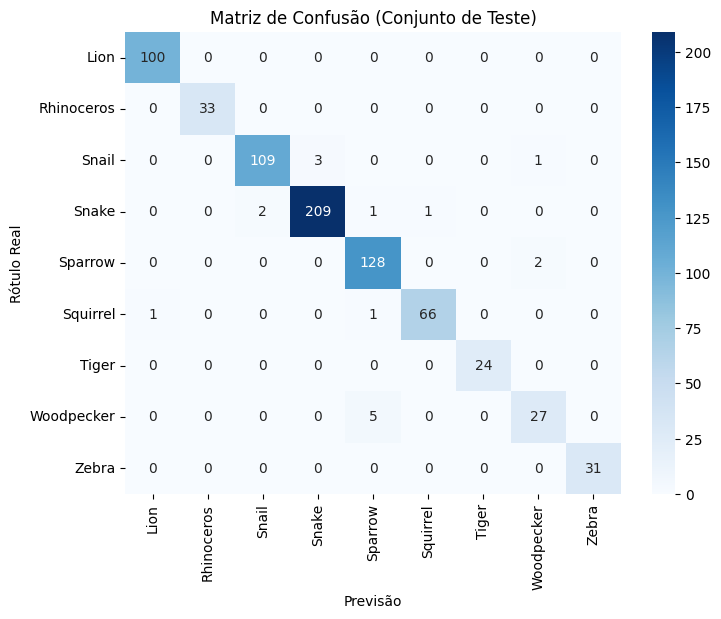

In [13]:
# Matriz de confusão

# Obter previsões e rótulos reais do conjunto de teste
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
class_names = classes  # use the already defined list of class names

# Visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Rótulo Real')
plt.title('Matriz de Confusão (Conjunto de Teste)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


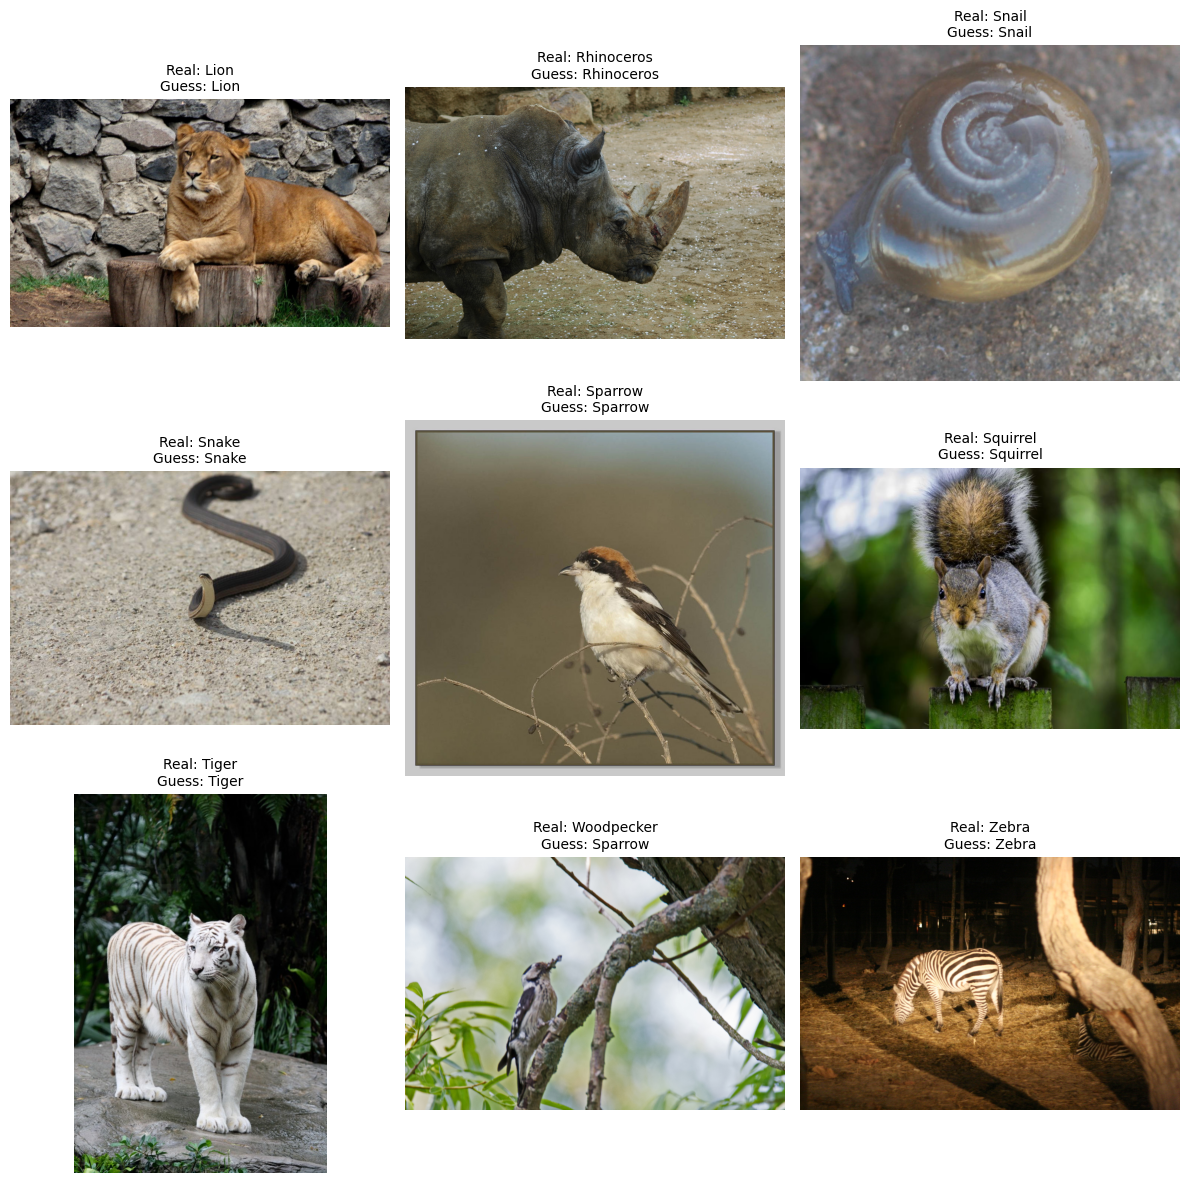

In [21]:
def preprocess_image(img, image_size=(224, 224)):
    img = cv.resize(img, image_size)
    img = img.astype("float32") / 255.0
    return img

fig, ax = plt.subplots(3, 3, figsize=(12, 12))  # grelha 3x3 para 9 classes

for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(data_train_path, class_name)

    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])

    img = cv.imread(img_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Pré-processar imagem como no treino
    input_img = preprocess_image(img_rgb)
    input_tensor = np.expand_dims(input_img, axis=0)  # [1, height, width, 3]

    prediction = model.predict(input_tensor)
    pred_class = tf.argmax(prediction, axis=1).numpy()[0]

    row = i // 3
    col = i % 3

    ax[row, col].imshow(img_rgb)
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Real: {class_name}\nGuess: {classes[pred_class]}", fontsize=10)

plt.tight_layout()
plt.show()
